In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

* Data Load

In [2]:
ppg_signal_3 = np.load('workspace/data/ica_ppg_signal_3.npy') # 5 min ppg

In [3]:
ecg_signal_3 = np.load('workspace/data/ica_ecg_signal_3.npy') # 5 min ecg

In [4]:
ppg_lb = np.load('workspace/data/ica_ppg_lb.npy')

In [5]:
ecg_lb = np.load('workspace/data/ica_ecg_lb.npy')

In [6]:
ppg_id = np.load('workspace/data/ica_ppg_id.npy')

In [7]:
ecg_id = np.load('workspace/data/ica_ecg_id.npy')

* ppg dataframe

In [8]:
df_ppg = pd.DataFrame(list(ppg_signal_3))

In [9]:
df_ppg['caseid'] = list(ppg_id)

In [10]:
df_ppg['label'] = list(ppg_lb)

In [11]:
df_ppg = df_ppg.dropna()

* ecg dataframe

In [12]:
df_ecg = pd.DataFrame(list(ecg_signal_3))

In [13]:
df_ecg['caseid'] = list(ecg_id)

In [14]:
df_ecg['label'] = list(ecg_lb)

In [15]:
df_ecg = df_ecg.dropna()

* concat df

In [16]:
len(list(set(df_ppg['caseid'])))

193

In [17]:
len(list(set(df_ecg['caseid'])))

206

In [18]:
len(list(set(df_ppg['caseid'])&set(df_ecg['caseid'])))

193

In [19]:
in_id = list(set(df_ppg['caseid'])&set(df_ecg['caseid']))

In [20]:
df_ecg['check'] = df_ecg['caseid'].map(lambda x : x in in_id)

In [21]:
df_ecg = df_ecg[df_ecg['check'] == True]

In [22]:
df_ecg = df_ecg.dropna()

In [23]:
df_ecg = df_ecg.drop('check', axis=1)

* bandpass filtring

In [24]:
from scipy.signal import butter
from scipy.signal import lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs # 50, fs:100 
    low = lowcut / nyq # 0.5/50 = 1/100, lowcut: 0.5
    high = highcut / nyq # 15/50 = 30/100, highcut : 15
    # order : frequency cut wave
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# BPF setting 0.5 ~ 15 hz
lowcut = 0.5
highcut = 15
fs = 100

In [25]:
df_ppg_bp_sig = []
for idx in range(len(df_ppg)):
    df_ppg_bp_sig.append(butter_bandpass_filter(df_ppg.iloc[idx][:-2], lowcut, highcut, fs))

In [26]:
df_ecg_bp_sig = []
for idx in range(len(df_ecg)):
    df_ecg_bp_sig.append(butter_bandpass_filter(df_ecg.iloc[idx][:-2], lowcut, highcut, fs))

* visualize

In [27]:
import matplotlib.pylab as plt

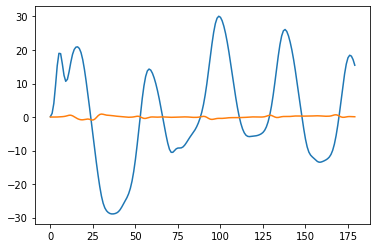

In [28]:
plt.plot(df_ppg_bp_sig[0])
plt.plot(df_ecg_bp_sig[0])

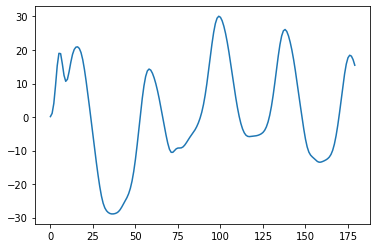

In [29]:
plt.plot(df_ppg_bp_sig[0])

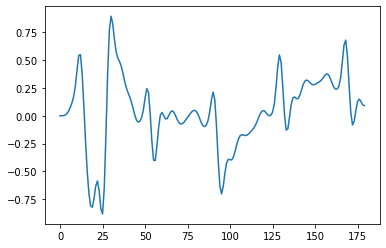

In [30]:
plt.plot(df_ecg_bp_sig[0])

In [32]:
X_train = [df_ppg_bp_sig, df_ecg_bp_sig]

In [33]:
y_train = list(df_ppg['label'].map(lambda x : 0 if x == 0 else 1))

In [34]:
X_train = np.asarray(df_ppg_bp_sig)
y_train = np.asarray(y_train)

In [35]:
len(X_train)

639

In [36]:
len(y_train)

639

In [37]:
X_train.shape

(639, 180)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
train_data, valid_data, train_labels, valid_labels = train_test_split(
    X_train, y_train, test_size=0.3, random_state=21
)

In [40]:
len(train_data), len(valid_data)

(447, 192)

In [41]:
valid_data, test_data, valid_labels, test_labels = train_test_split(
    valid_data, valid_labels, test_size=0.5, random_state=21
)

In [42]:
len(valid_data), len(test_data)

(96, 96)

In [44]:
import tensorflow as tf
# minmaxnormalization
min_tra = tf.reduce_min(np.float32(train_data))
# max
max_tra = tf.reduce_max(np.float32(train_data))
# min
min_val = tf.reduce_min(np.float32(valid_data))
# min
max_val = tf.reduce_max(np.float32(valid_data))

min_tes = tf.reduce_min(np.float32(test_data))
# min
max_tes = tf.reduce_max(np.float32(test_data))

In [45]:
train_data = (train_data - min_tra) / (max_tra - min_tra)
valid_data = (valid_data - min_val) / (max_val - min_val)
test_data = (test_data - min_tes) / (max_tes - min_tes)

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dropout, Conv1D, GlobalMaxPooling1D, Dense, BatchNormalization, ReLU, MaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

In [66]:
model = Sequential()
model.add(Conv1D(16, 16,strides=2, activation='relu',input_shape=(180,1)))
model.add(Conv1D(16, 16,strides=2, activation='relu',padding="same"))
model.add(MaxPool1D(2))
model.add(Conv1D(64, 8,strides=2, activation='relu',padding="same"))
model.add(Conv1D(64, 8,strides=2, activation='relu',padding="same"))
#model.add(MaxPool1D(2))
model.add(Conv1D(128, 4,strides=2, activation='relu',padding="same"))
model.add(Conv1D(128, 4,strides=2, activation='relu',padding="same"))
model.add(MaxPool1D(2))
model.add(Conv1D(256, 2,strides=1, activation='relu',padding="same"))
model.add(Conv1D(256, 2,strides=1, activation='relu',padding="same"))
#model.add(MaxPool1D(2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [67]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_66 (Conv1D)          (None, 83, 16)            272       
                                                                 
 conv1d_67 (Conv1D)          (None, 42, 16)            4112      
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 21, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_68 (Conv1D)          (None, 11, 64)            8256      
                                                                 
 conv1d_69 (Conv1D)          (None, 6, 64)             32832     
                                                                 
 conv1d_70 (Conv1D)          (None, 3, 128)            32896     
                                                     

In [68]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [69]:
history = model.fit(train_data, train_labels, epochs=500, validation_data=(test_data, test_labels))

Epoch 1/500


2022-11-23 02:01:37.054139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-11-23 02:01:37.535846: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2022-11-23 02:01:37.535857: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-23 02:01:37.535887: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-23 02:01:37.923599: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 2s 12ms/step - loss: 0.6484 - acc: 0.6689 - val_loss: 0.6061 - val_acc: 0.7500
Epoch 2/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6444 - acc: 0.6667 - val_loss: 0.5807 - val_acc: 0.7500
Epoch 3/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6443 - acc: 0.6667 - val_loss: 0.5792 - val_acc: 0.7500
Epoch 4/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6459 - acc: 0.6667 - val_loss: 0.6324 - val_acc: 0.7500
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 0.6559 - acc: 0.6667 - val_loss: 0.6183 - val_acc: 0.7500
Epoch 6/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6412 - acc: 0.6667 - val_loss: 0.5722 - val_acc: 0.7500
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 0.6370 - acc: 0.6667 - val_loss: 0.5855 - val_acc: 0.7500
Epoch 8/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6383 - acc: 0.6667 

* model1

In [51]:
model = Sequential()
# conv1
model.add(Conv1D(64, 10, padding='valid', strides=1,input_shape=(180, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv2
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv3
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv4
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv5
model.add(Conv1D(64, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))


model.add(GlobalMaxPooling1D())
model.add(Dense(320))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 171, 64)           704       
                                                                 
 batch_normalization_10 (Bat  (None, 171, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 171, 64)           0         
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 85, 64)           0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 85, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 85, 128)          

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [54]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [55]:
history = model.fit(train_data, train_labels, epochs=500, validation_data=(test_data, test_labels))

Epoch 1/500


2022-11-23 01:35:18.941439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-11-23 01:35:19.425190: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2022-11-23 01:35:19.425204: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-23 01:35:19.425239: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-23 01:35:19.843817: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 2s 20ms/step - loss: 0.9670 - acc: 0.5727 - val_loss: 0.8462 - val_acc: 0.7500
Epoch 2/500
14/14 [==============================] - 0s 5ms/step - loss: 0.7680 - acc: 0.6085 - val_loss: 0.5917 - val_acc: 0.7083
Epoch 3/500
14/14 [==============================] - 0s 4ms/step - loss: 0.7833 - acc: 0.5906 - val_loss: 1.8493 - val_acc: 0.2812
Epoch 4/500
14/14 [==============================] - 0s 4ms/step - loss: 0.6805 - acc: 0.6219 - val_loss: 0.8388 - val_acc: 0.4479
Epoch 5/500
14/14 [==============================] - 0s 4ms/step - loss: 0.7149 - acc: 0.6286 - val_loss: 0.8908 - val_acc: 0.4062
Epoch 6/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6768 - acc: 0.6600 - val_loss: 0.8928 - val_acc: 0.3854
Epoch 7/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6777 - acc: 0.6711 - val_loss: 0.6357 - val_acc: 0.6771
Epoch 8/500
14/14 [==============================] - 0s 3ms/step - loss: 0.6504 - acc: 0.6689 

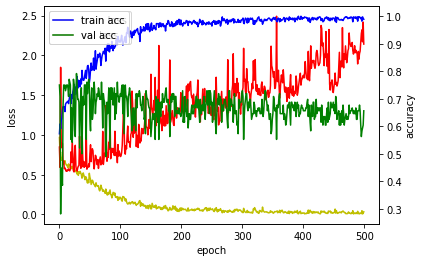

In [56]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

* model2

In [57]:
model = Sequential()
# conv1
model.add(Conv1D(64, 10, padding='valid', strides=1,input_shape=(180, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv2
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv3
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())
model.add(Dense(320))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 171, 64)           704       
                                                                 
 batch_normalization_15 (Bat  (None, 171, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_15 (ReLU)             (None, 171, 64)           0         
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 85, 64)           0         
 g1D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 85, 64)            0         
                                                                 
 conv1d_16 (Conv1D)          (None, 85, 128)          

In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [60]:
history = model.fit(train_data, train_labels, epochs=500, validation_data=(test_data, test_labels))

Epoch 1/500
14/14 [==============================] - 1s 9ms/step - loss: 1.6048 - acc: 0.5861 - val_loss: 1.0275 - val_acc: 0.3333
Epoch 2/500
14/14 [==============================] - 0s 3ms/step - loss: 0.9969 - acc: 0.5817 - val_loss: 0.6725 - val_acc: 0.6979
Epoch 3/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8205 - acc: 0.6756 - val_loss: 0.5853 - val_acc: 0.7083
Epoch 4/500
14/14 [==============================] - 0s 3ms/step - loss: 0.7872 - acc: 0.6018 - val_loss: 1.4044 - val_acc: 0.3333
Epoch 5/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8910 - acc: 0.5928 - val_loss: 0.6361 - val_acc: 0.7708
Epoch 6/500
14/14 [==============================] - 0s 3ms/step - loss: 0.9495 - acc: 0.6018 - val_loss: 1.4998 - val_acc: 0.2708
Epoch 7/500
14/14 [==============================] - 0s 3ms/step - loss: 0.9281 - acc: 0.5973 - val_loss: 1.3332 - val_acc: 0.3333
Epoch 8/500
14/14 [==============================] - 0s 3ms/step - loss: 0.7237 - a

* model3

In [64]:
model = Sequential()
# conv1
model.add(Conv1D(64, 10, padding='valid', strides=1,input_shape=(180, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv2
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))


model.add(GlobalMaxPooling1D())
model.add(Dense(320))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [65]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [66]:
history = model.fit(train_data, train_labels, epochs=500, validation_data=(test_data, test_labels))

Epoch 1/500
14/14 [==============================] - 0s 8ms/step - loss: 1.7785 - acc: 0.5660 - val_loss: 0.8367 - val_acc: 0.7500
Epoch 2/500
14/14 [==============================] - 0s 3ms/step - loss: 1.0035 - acc: 0.5817 - val_loss: 0.8324 - val_acc: 0.5000
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 0.8519 - acc: 0.6107 - val_loss: 0.6369 - val_acc: 0.6354
Epoch 4/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8965 - acc: 0.6264 - val_loss: 0.6174 - val_acc: 0.6562
Epoch 5/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8098 - acc: 0.6130 - val_loss: 0.5859 - val_acc: 0.7500
Epoch 6/500
14/14 [==============================] - 0s 3ms/step - loss: 0.7400 - acc: 0.6488 - val_loss: 1.1359 - val_acc: 0.3021
Epoch 7/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8985 - acc: 0.5794 - val_loss: 0.5614 - val_acc: 0.7292
Epoch 8/500
14/14 [==============================] - 0s 2ms/step - loss: 0.6924 - a